multivariate times series
regular times series
var model et non arima
verifier si stationnary
use referencing if not

- separation  en 2 dataset opour faire une concatenation a la fin




In [39]:
#importing the libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, time
from vacances_scolaires_france import SchoolHolidayDates
import sys
from impyute.imputation.cs import mice
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
#pip install vacances-scolaires-france
#pip3 install impyute
#yconda install -c plotly plotly=4.0.0
# my fonctions
def conv(data):
    data["date"] = data.timestamp.apply(lambda x : x.split('T')[0])
    data["datetime_perso"] = data.timestamp.apply(lambda x : get_format_the_date(x))
    data['year']=data['datetime_perso'].dt.year
    data['month']=data['datetime_perso'].dt.month
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['hours'] = data['timestamp'].dt.hour
    return data

## get season
def get_season(doy):
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)
    if doy in spring:
        season = 'spring'
    elif doy in summer:
      season = 'summer'
    elif doy in fall:
        season = 'fall'
    else:
        season = 'winter'
    return season

## verifie si jour ferie
def easter_date(year):
    a = year // 100
    b = year % 100
    c = (3 * (a + 25)) // 4
    d = (3 * (a + 25)) % 4
    e = (8 * (a + 11)) // 25
    f = (5 * a + b) % 19
    g = (19 * f + c - e) % 30
    h = (f + 11 * g) // 319
    j = (60 * (5 - d) + b) // 4
    k = (60 * (5 - d) + b) % 4
    m = (2 * j - k - g + h) % 7
    n = (g - h + m + 114) // 31
    p = (g - h + m + 114) % 31
    day = p + 1
    month = n
    return datetime(year, month, day)

def is_ferie(the_date):
    year = the_date.year
    easter = easter_date(year)
    days = [
        datetime(year, 1, 1),  # Premier de l'an
        easter + timedelta(days=1),  # Lundi de Pâques
        datetime(year, 5, 1),  # Fête du Travail
        datetime(year, 5, 8),  # Victoire de 1945
        easter + timedelta(days=39),  # Ascension
        easter + timedelta(days=49),  # Pentecôte
        datetime(year, 7, 14),  # Fête Nationale
        datetime(year, 8, 15),  # Assomption
        datetime(year, 11, 1),  # Toussaint
        datetime(year, 11, 11),  # Armistice 1918
        datetime(year, 12, 25),  # Noël
    ]
    return the_date in days

def get_format_the_date(timestamp):
    do = datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%S.%f')
    d5 = do.replace(minute=0, hour=0, second=0, microsecond=0).isoformat(' ')
    the_date = datetime.strptime(d5, "%Y-%m-%d %H:%M:%S")
    return the_date

def business_day(timestamp):
    if not is_ferie(timestamp) and timestamp.isoweekday() not in [6, 7]:
        return True
    else:
        return False
    
  

In [40]:
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

In [41]:
#creating a function to encapsulate preprocessing, to mkae it easy to replicate on  submission data
# tester aussi avec dataInt et DataTeat separer dans une future version

def processing(dataInt):
    ## missing value
    df = dataInt.copy()
    df_num = df.drop(['timestamp','loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2', 'loc_secondary_3'], axis=1)
    df_NonNum = df.select_dtypes(include=[np.object])
    imputed_training_mice = mice(df_num.values)
    data_mice = pd.DataFrame(imputed_training_mice, columns = df_num.columns, index = list(df.index.values))
    dClean = data_mice.join(df_NonNum)
    ## drop variable inutile
    d_tr = dClean.drop(['loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2', 'loc_secondary_3'], axis=1)
    ## create extra attribute
    conv(d_tr)
    d_tr['timestamp'] = pd.to_datetime(d_tr.timestamp, format = '%Y-%m-%dT%H:%M:%S.%f')
    ## create season and rangeInYear
    s = pd.to_datetime(pd.Series(d_tr['timestamp']))
    d_tr['rangeInYear'] = s.dt.strftime('%j').astype(int)
    #create jours working days
    d_tr['is_business_day'] = d_tr['datetime_perso'].apply(lambda e : int(business_day(e)))
    # Is it an holiday for zone A, B or C?
    d = SchoolHolidayDates()
    d_tr['is_holiday'] = d_tr['datetime_perso'].apply(lambda f : int(d.is_holiday(datetime.date(f))))
    d_tr['season'] = d_tr['rangeInYear'].apply(lambda d : get_season(d))
    dataInt1 = d_tr.drop(['rangeInYear', 'datetime_perso', 'date'], axis=1)
    return (dataInt1)    



--------------------------------------------------------------------------------------------------------------------

In [105]:
# creere un je
dataInt_raw = pd.read_csv('./data_set1/input_training_ssnsrY0.csv')
dataOut_raw = pd.read_csv('./data_set1/output_training_Uf11I9I.csv')
dataTest_raw = pd.read_csv('./data_set1/input_test_cdKcI0e.csv')
data = pd.concat([dataInt_raw, dataOut_raw[['consumption_1', 'consumption_2']]], axis=1)
data.head()
data.columns
#----------------------

Index(['ID', 'timestamp', 'temp_1', 'temp_2', 'mean_national_temp',
       'humidity_1', 'humidity_2', 'loc_1', 'loc_2', 'loc_secondary_1',
       'loc_secondary_2', 'loc_secondary_3', 'consumption_secondary_1',
       'consumption_secondary_2', 'consumption_secondary_3', 'consumption_1',
       'consumption_2'],
      dtype='object')

In [111]:
dataNew = processing(data)
dataNew['timestamp'] = pd.to_datetime(dataNew['timestamp'])
dataNew.set_index('timestamp', inplace=True)
dataNew.head(2)

,ID,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,consumption_1,consumption_2,year,month,hours,is_business_day,is_holiday,season
timestamp,,,,,,,,,,,,,,,,,
2016-11-01 00:00:00,0.0,8.3,11.634707,11.1,95.0,78.366622,143.0,74.0,168.0,100.0,93.0,2016,11,0,0,1,fall
2016-11-01 01:00:00,1.0,8.0,11.262888,11.1,98.0,79.931832,141.0,60.0,162.0,101.0,94.0,2016,11,1,0,1,fall


In [112]:
categorical_features = ['season']
for var in categorical_features:
    dataNew[var] = dataNew[var].astype('category')
list(dataNew.columns)  

['ID',
 'temp_1',
 'temp_2',
 'mean_national_temp',
 'humidity_1',
 'humidity_2',
 'consumption_secondary_1',
 'consumption_secondary_2',
 'consumption_secondary_3',
 'consumption_1',
 'consumption_2',
 'year',
 'month',
 'hours',
 'is_business_day',
 'is_holiday',
 'season']

In [114]:

from pandas.api.types import CategoricalDtype
#all_data = pd.concat([dataInt_raw, dataTest_raw])
#for column in categorical_features:
#    dataNew[column] = dataNew[column].astype(CategoricalDtype(categories = dataNew[column].unique(), ordered=True))


In [115]:
dataNeww = pd.get_dummies(dataNew, drop_first=True)
dataNew = dataNew[dataNew.columns]
list(dataNew.columns)


['ID',
 'temp_1',
 'temp_2',
 'mean_national_temp',
 'humidity_1',
 'humidity_2',
 'consumption_secondary_1',
 'consumption_secondary_2',
 'consumption_secondary_3',
 'consumption_1',
 'consumption_2',
 'year',
 'month',
 'hours',
 'is_business_day',
 'is_holiday',
 'season']

In [117]:
dataNew.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2016-11-01 00:00:00 to 2017-10-31 23:00:00
Data columns (total 17 columns):
ID                         8760 non-null float64
temp_1                     8760 non-null float64
temp_2                     8760 non-null float64
mean_national_temp         8760 non-null float64
humidity_1                 8760 non-null float64
humidity_2                 8760 non-null float64
consumption_secondary_1    8760 non-null float64
consumption_secondary_2    8760 non-null float64
consumption_secondary_3    8760 non-null float64
consumption_1              8760 non-null float64
consumption_2              8760 non-null float64
year                       8760 non-null int64
month                      8760 non-null int64
hours                      8760 non-null int64
is_business_day            8760 non-null int64
is_holiday                 8760 non-null int64
season                     8760 non-null category
dtypes: category(1), float64(11),

In [118]:
dataNew.head(2)

,ID,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,consumption_1,consumption_2,year,month,hours,is_business_day,is_holiday,season
timestamp,,,,,,,,,,,,,,,,,
2016-11-01 00:00:00,0.0,8.3,11.634707,11.1,95.0,78.366622,143.0,74.0,168.0,100.0,93.0,2016,11,0,0,1,fall
2016-11-01 01:00:00,1.0,8.0,11.262888,11.1,98.0,79.931832,141.0,60.0,162.0,101.0,94.0,2016,11,1,0,1,fall


In [119]:
dataClean = dataNew.values

In [120]:
#dataNew = dataNew.drop(['season'], axis=1)
list(dataNew.columns) 


['ID',
 'temp_1',
 'temp_2',
 'mean_national_temp',
 'humidity_1',
 'humidity_2',
 'consumption_secondary_1',
 'consumption_secondary_2',
 'consumption_secondary_3',
 'consumption_1',
 'consumption_2',
 'year',
 'month',
 'hours',
 'is_business_day',
 'is_holiday',
 'season']

In [121]:
dataNew.head(2)

,ID,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,consumption_1,consumption_2,year,month,hours,is_business_day,is_holiday,season
timestamp,,,,,,,,,,,,,,,,,
2016-11-01 00:00:00,0.0,8.3,11.634707,11.1,95.0,78.366622,143.0,74.0,168.0,100.0,93.0,2016,11,0,0,1,fall
2016-11-01 01:00:00,1.0,8.0,11.262888,11.1,98.0,79.931832,141.0,60.0,162.0,101.0,94.0,2016,11,1,0,1,fall


In [122]:
# Providing the index to the time series
dataNew = pd.DataFrame(data = dataNew.values, 
                           columns = dataNew.columns,
                           index = pd.date_range(start = '2016-11-01 00:00:00', 
                                                 periods = 8760, 
                                                 freq = 'H'))

In [123]:
dataNew.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2016-11-01 00:00:00 to 2017-10-31 23:00:00
Freq: H
Data columns (total 17 columns):
ID                         8760 non-null object
temp_1                     8760 non-null object
temp_2                     8760 non-null object
mean_national_temp         8760 non-null object
humidity_1                 8760 non-null object
humidity_2                 8760 non-null object
consumption_secondary_1    8760 non-null object
consumption_secondary_2    8760 non-null object
consumption_secondary_3    8760 non-null object
consumption_1              8760 non-null object
consumption_2              8760 non-null object
year                       8760 non-null object
month                      8760 non-null object
hours                      8760 non-null object
is_business_day            8760 non-null object
is_holiday                 8760 non-null object
season                     8760 non-null object
dtypes: object(17)
memory usage: 

In [77]:
#data.info()

In [124]:
dataNew.head(2)

,ID,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,consumption_1,consumption_2,year,month,hours,is_business_day,is_holiday,season
2016-11-01 00:00:00,0,8.3,11.6347,11.1,95,78.3666,143,74,168,100,93,2016,11,0,0,1,fall
2016-11-01 01:00:00,1,8,11.2629,11.1,98,79.9318,141,60,162,101,94,2016,11,1,0,1,fall


In [79]:
#data.head(2)

In [80]:
#data.head(2)

In [81]:
#print(data.columns)


In [62]:
print(dataNew.index.dtype)


datetime64[ns]


In [63]:
#dataNew.index = pd.to_datetime(data.index)


In [64]:
#dataNew.index.dtype

dtype('<M8[ns]')

In [125]:
dataNew.head(2)


,ID,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,consumption_1,consumption_2,year,month,hours,is_business_day,is_holiday,season
2016-11-01 00:00:00,0,8.3,11.6347,11.1,95,78.3666,143,74,168,100,93,2016,11,0,0,1,fall
2016-11-01 01:00:00,1,8,11.2629,11.1,98,79.9318,141,60,162,101,94,2016,11,1,0,1,fall


In [126]:
data1 = dataNew.loc[:, ['temp_1', 'temp_2','mean_national_temp', 'humidity_1', 'humidity_2', 
                    'consumption_secondary_1', 'consumption_secondary_2', 'consumption_secondary_3','consumption_1']]
data2 = dataNew.loc[:, ['temp_1', 'temp_2','mean_national_temp', 'humidity_1', 'humidity_2', 
                    'consumption_secondary_1', 'consumption_secondary_2', 'consumption_secondary_3','consumption_2']]

print(data1.shape, data2.shape)

(8760, 9) (8760, 9)


In [127]:
data1.head()

,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,consumption_1
2016-11-01 00:00:00,8.3,11.6347,11.1,95,78.3666,143,74,168,100
2016-11-01 01:00:00,8,11.2629,11.1,98,79.9318,141,60,162,101
2016-11-01 02:00:00,6.8,11.1974,11,97,79.7276,142,60,164,100
2016-11-01 03:00:00,7.5,10.9296,10.9,99,80.6553,139,60,162,101
2016-11-01 04:00:00,6.1,10.8059,10.8,98,80.801,154,60,164,100


In [128]:
cols_plot = data1.columns

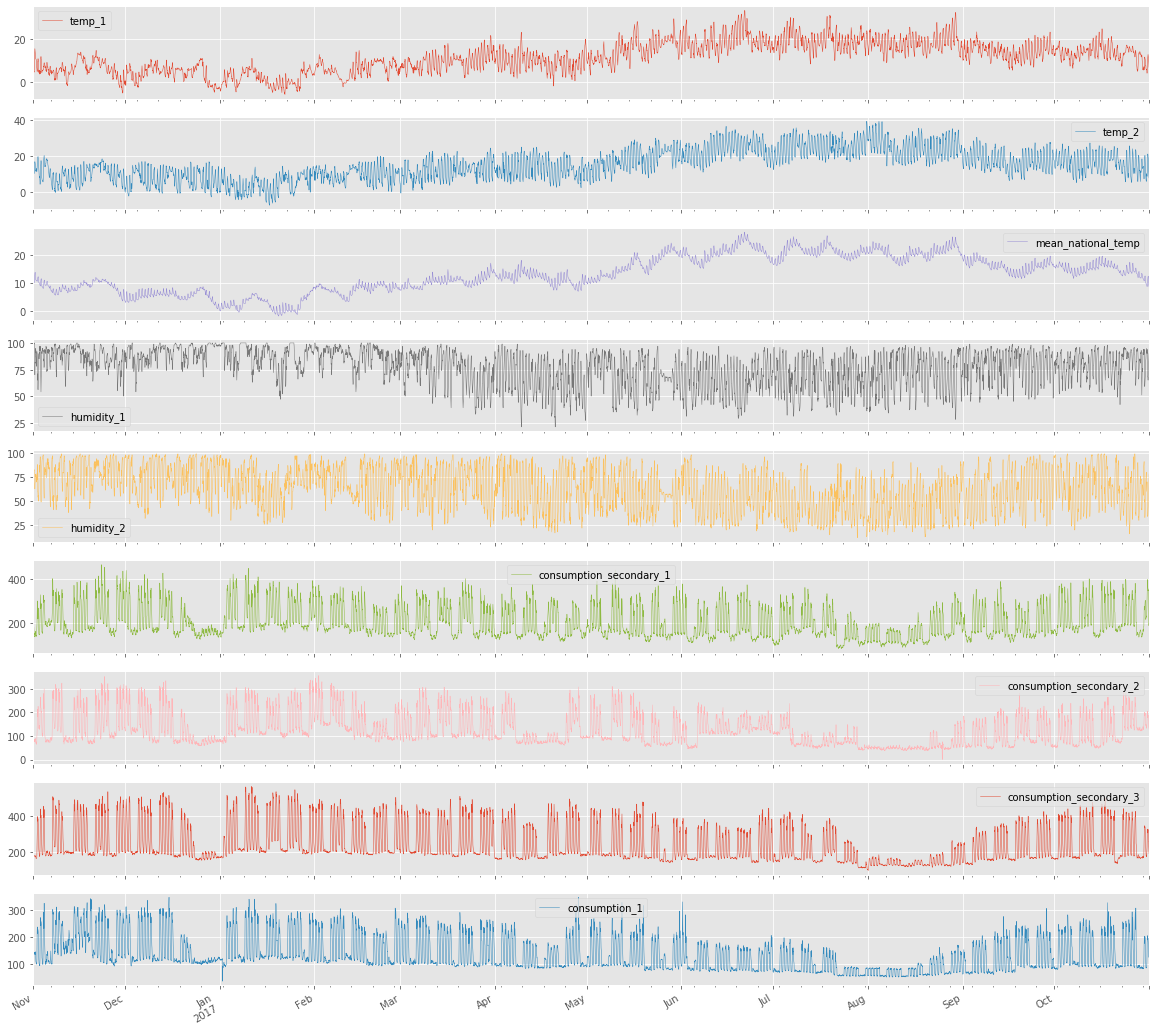

In [129]:
axes = data1[cols_plot].plot(alpha=1., linewidth=.5, figsize=(20, 20), subplots=True, sharex=True)


In [130]:
dataNew.head(2)

,ID,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,consumption_1,consumption_2,year,month,hours,is_business_day,is_holiday,season
2016-11-01 00:00:00,0,8.3,11.6347,11.1,95,78.3666,143,74,168,100,93,2016,11,0,0,1,fall
2016-11-01 01:00:00,1,8,11.2629,11.1,98,79.9318,141,60,162,101,94,2016,11,1,0,1,fall


In [131]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2016-11-01 00:00:00 to 2017-10-31 23:00:00
Freq: H
Data columns (total 9 columns):
temp_1                     8760 non-null object
temp_2                     8760 non-null object
mean_national_temp         8760 non-null object
humidity_1                 8760 non-null object
humidity_2                 8760 non-null object
consumption_secondary_1    8760 non-null object
consumption_secondary_2    8760 non-null object
consumption_secondary_3    8760 non-null object
consumption_1              8760 non-null object
dtypes: object(9)
memory usage: 684.4+ KB


In [132]:
import plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [133]:
#groupBy_whole = data1.groupby('timestamp').mean()
groupBy_whole = data1.resample('D').mean()


trace1 = go.Scatter(
        x=groupBy_whole.temp_1.index, 
        y=groupBy_whole.temp_1, 
        mode = 'lines',
        name = 'temp_1',
        marker = dict(color = 'rgba(0, 191, 205, 0.4)'))
trace2 = go.Scatter(
        x=groupBy_whole.temp_2.index, 
        y=groupBy_whole.temp_2, 
        mode = 'lines',
        name = 'temp_2',
        marker = dict(color = 'rgba(1, 50, 2, 0.2)'))
trace3 = go.Scatter(
        x=groupBy_whole.mean_national_temp.index, 
        y=groupBy_whole.mean_national_temp, 
        mode = 'lines',
        name = 'mean_national_temp',
        marker = dict(color = 'rgba(0, 61, 80, 0.6)'))
trace4 = go.Scatter(
        x=groupBy_whole.humidity_1.index, 
        y=groupBy_whole.humidity_1, 
        name = 'humidity_1',
        line = dict(
            color = 'rgba(0, 191, 205, 0.6)',
            width = 2,
            dash = 'dot'))
trace5 = go.Scatter(
        x=groupBy_whole.humidity_2.index, 
        y=groupBy_whole.humidity_2, 
        name = 'humidity_2',
        line = dict(
            color = 'rgba(1, 50, 2, 0.4)',
            width = 2,
            dash = 'dot'))

data = [trace1, trace2, trace3, trace4, trace5]

# layout=dict(title="Time Series Plot for Mean Daily temperature", xaxis={'title':'Date'}, yaxis={'title':'Temp/Humidity'})
layout = dict(
    title="Time Series Plot for Mean Daily temperature",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=4,
                     label='4m',
                     step='month',
                     stepmode='backward'),
                dict(count=1,
                    label='YTD',
                    step='year',
                    stepmode='todate'),
                dict(count=1,
                    label='1y',
                    step='year',
                    stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    ),
    yaxis={'title':'Temp/Humidity'}
)
fig=dict(data=data,layout=layout)
iplot(fig)

DataError: No numeric types to aggregate

In [37]:
import plotly
import matplotlib.pyplot as plt
data1[['temp_1','temp_2', 'mean_national_temp']].iplot(
    mode='lines+markers',
    opacity=0.8,
    size=8,
    symbol=1,
    xTitle='Time',
    yTitle='Temperature',
    title='Temperature over last 10 years')

AttributeError: 'DataFrame' object has no attribute 'iplot'

In [38]:
data1['consumption_1'].plot()
data1['consumption_2'].plot()

KeyError: 'consumption_1'

In [260]:
print(data1.describe())

            temp_1       temp_2  mean_national_temp   humidity_1   humidity_2  \
count  8760.000000  8760.000000         8760.000000  8760.000000  8760.000000   
mean     11.574033    15.243267           13.173858    77.154767    63.280460   
std       7.091934     8.445574            6.474700    16.547083    21.639047   
min      -5.700000    -7.200000           -1.800000    21.000000    12.000000   
25%       6.100000     9.100000            8.200000    66.000000    46.000000   
50%      11.450000    14.700000           12.800000    81.000000    64.000000   
75%      16.700000    21.350433           18.700000    91.000000    82.000000   
max      33.600000    39.300000           28.300000   100.000000    99.000000   

       consumption_secondary_1  consumption_secondary_2  \
count              8760.000000              8760.000000   
mean                203.025114               123.581735   
std                  69.792811                65.036526   
min                  84.000000    

In [261]:
cols = data1.columns


In [262]:
cols

Index(['temp_1', 'temp_2', 'mean_national_temp', 'humidity_1', 'humidity_2',
       'consumption_secondary_1', 'consumption_secondary_2',
       'consumption_secondary_3', 'consumption_1', 'consumption_2'],
      dtype='object')

In [263]:
#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#scheck the eigenvalues
coint_johansen(data1,-1,1).eig

array([1.73175657e-01, 8.97826797e-02, 7.48674682e-02, 5.45979769e-02,
       4.64003049e-02, 3.96298446e-02, 3.31423355e-02, 1.56190312e-02,
       3.49738590e-03, 9.85551495e-05])

In [264]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

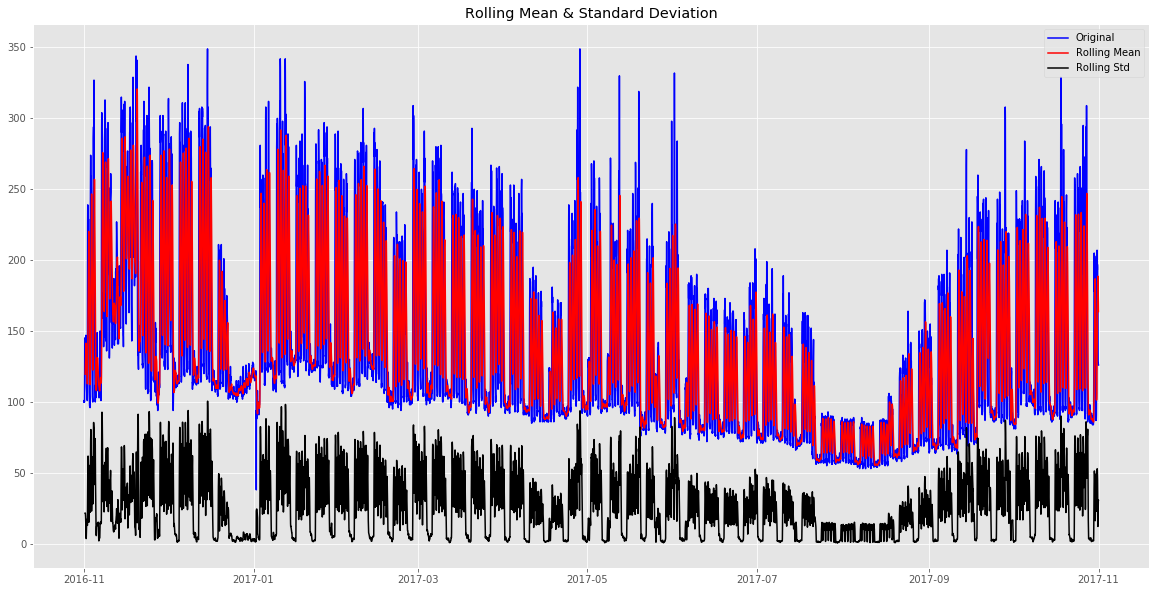

Results of Dickey-Fuller Test:
Test Statistic                -8.125894e+00
p-value                        1.123480e-12
#Lags Used                     3.700000e+01
Number of Observations Used    8.722000e+03
Critical Value (1%)           -3.431100e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64
Results of KPSS Test:
Test Statistic            8.00514
p-value                   0.01000
Lags Used                37.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1707: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [265]:
test_stationarity(data1['consumption_1'])

In [225]:
cols

Index(['temp_1', 'temp_2', 'mean_national_temp', 'humidity_1', 'humidity_2',
       'consumption_secondary_1', 'consumption_secondary_2',
       'consumption_secondary_3', 'consumption_1', 'consumption_2'],
      dtype='object')

In [184]:
#SPLIT
tscv = TimeSeriesSplit(n_splits=12)
print(tscv)
for train_index, test_index in tscv.split(data1):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = data1.iloc[train_index, :], data1.iloc[test_index, :]
    y_train, y_test = data1.iloc[train_index, :], data1.iloc[test_index, :]

TimeSeriesSplit(max_train_size=None, n_splits=12)
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 23

In [185]:
from statsmodels.tsa.vector_ar.var_model import VAR
train.head()
print(len(train_index))


8087


In [186]:
y_train.index

DatetimeIndex(['2016-11-01 00:00:00', '2016-11-01 01:00:00',
               '2016-11-01 02:00:00', '2016-11-01 03:00:00',
               '2016-11-01 04:00:00', '2016-11-01 05:00:00',
               '2016-11-01 06:00:00', '2016-11-01 07:00:00',
               '2016-11-01 08:00:00', '2016-11-01 09:00:00',
               ...
               '2017-10-03 14:00:00', '2017-10-03 15:00:00',
               '2017-10-03 16:00:00', '2017-10-03 17:00:00',
               '2017-10-03 18:00:00', '2017-10-03 19:00:00',
               '2017-10-03 20:00:00', '2017-10-03 21:00:00',
               '2017-10-03 22:00:00', '2017-10-03 23:00:00'],
              dtype='datetime64[ns]', length=8087, freq=None)

In [187]:
X_train.index

DatetimeIndex(['2016-11-01 00:00:00', '2016-11-01 01:00:00',
               '2016-11-01 02:00:00', '2016-11-01 03:00:00',
               '2016-11-01 04:00:00', '2016-11-01 05:00:00',
               '2016-11-01 06:00:00', '2016-11-01 07:00:00',
               '2016-11-01 08:00:00', '2016-11-01 09:00:00',
               ...
               '2017-10-03 14:00:00', '2017-10-03 15:00:00',
               '2017-10-03 16:00:00', '2017-10-03 17:00:00',
               '2017-10-03 18:00:00', '2017-10-03 19:00:00',
               '2017-10-03 20:00:00', '2017-10-03 21:00:00',
               '2017-10-03 22:00:00', '2017-10-03 23:00:00'],
              dtype='datetime64[ns]', length=8087, freq=None)

In [188]:
Exog = ['temp_1', 'temp_2', 'mean_national_temp', 'humidity_1', 'humidity_2', 'consumption_secondary_1', 'consumption_secondary_2', 'consumption_secondary_3']

In [189]:
Endog = ['consumption_1', 'consumption_2']

In [199]:
model = VAR(endog=y_train[Endog], exog=X_train[Exog])

/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [195]:
model_fit = model.fit(2)


In [196]:
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Jul, 2019
Time:                     23:34:59
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    9.64315
Nobs:                     8085.00    HQIC:                   9.62835
Log likelihood:          -61809.7    FPE:                    15072.8
AIC:                      9.62065    Det(Omega_mle):         15024.5
--------------------------------------------------------------------
Results for equation consumption_1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -1.887404         1.384972           -1.363           0.173
exog0         0.018235         0.055458            0.329           0.742
exog1        -0.099248         0.045035           -2.204           0.028
exog2      

In [197]:
prediction = model_fit.forecast(model_fit.y, steps=len(test))

ValueError: Please provide an exog_future argument to the forecast method.

In [198]:
print(len(prediction))
print(cols)

NameError: name 'prediction' is not defined

In [83]:
import math 
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,10):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', math.sqrt(mean_squared_error(pred[i], test[i])))

rmse value for temp_1 is :  3.7285159588342216
rmse value for temp_2 is :  5.04864959904927
rmse value for mean_national_temp is :  2.0228308850407797
rmse value for humidity_1 is :  13.389437306290047
rmse value for humidity_2 is :  21.16882677603723
rmse value for consumption_secondary_1 is :  71.30424362027433
rmse value for consumption_secondary_2 is :  57.882534690136204
rmse value for consumption_secondary_3 is :  92.96540052951377
rmse value for consumption_1 is :  61.22427264972867
rmse value for consumption_2 is :  42.21340615322829


In [84]:
pred.head()

,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,consumption_1,consumption_2
0,13.9332,14.1826,15.7429,73.1728,89.6637,151.628,59.765,162.937,77.1031,99.9569
1,13.7056,14.2962,15.6894,74.1928,88.2812,157.298,64.655,167.676,82.3106,104.109
2,13.5163,14.439,15.6406,75.0605,86.8546,162.935,69.6005,173.04,87.5507,108.344
3,13.3638,14.6089,15.5976,75.7786,85.3883,168.47,74.536,178.858,92.7557,112.563
4,13.2462,14.8031,15.5607,76.3517,83.8888,173.84,79.4009,184.973,97.8627,116.681


In [85]:
test.head()

,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,consumption_1,consumption_2
2017-09-09 22:00:00,12.8,13.5,15.6,78.0,94.0,147.0,49.0,157.0,73.0,93.0
2017-09-09 23:00:00,12.0,13.0,15.4,83.0,92.0,150.0,51.0,153.0,74.0,92.0
2017-09-10 00:00:00,11.6,13.0,15.4,86.0,95.0,149.0,52.0,152.0,72.0,91.0
2017-09-10 01:00:00,10.9,12.3,15.4,87.0,96.0,148.0,50.0,151.0,68.0,89.0
2017-09-10 02:00:00,10.1,11.7,15.4,89.0,96.0,151.0,51.0,157.0,68.0,90.0


KSS : test statistic Greater critical value => non stationnary


    Case 1: Both tests conclude that the series is not stationary -> series is not stationary
    Case 2: Both tests conclude that the series is stationary -> series is stationary
    Case 3: KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary
    Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary


differencing

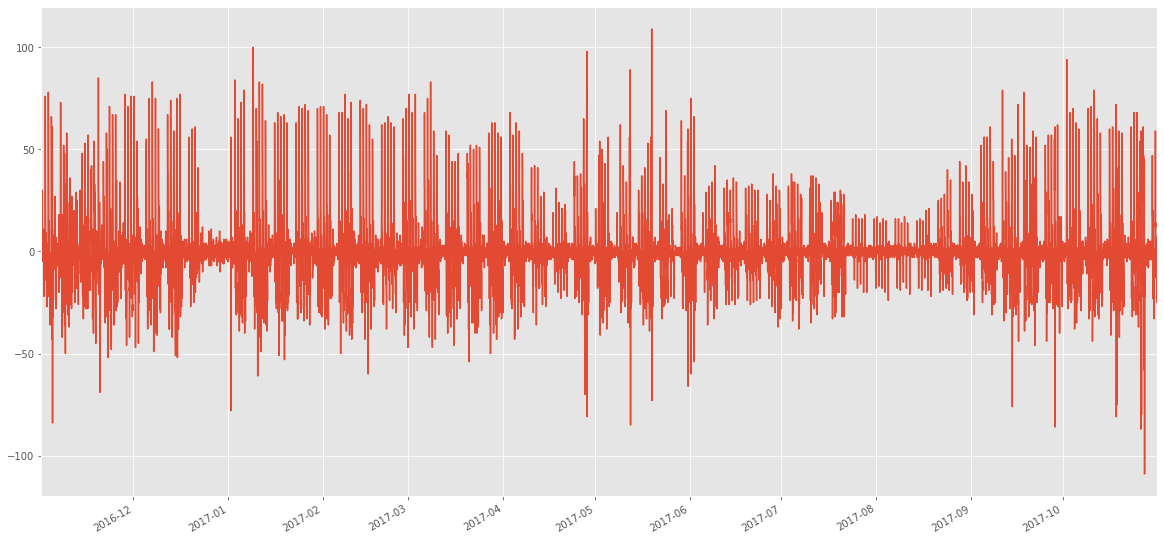

In [445]:
data1['consumption_1_diff'] = data1['consumption_1'] - data1['consumption_1'].shift(1)
data1['consumption_1_diff'].dropna().plot()


In [446]:
data1.head()

,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,consumption_1,consumption_2,consumption_1_diff
2016-11-01 00:00:00,8.3,12.643470,11.1,95.0,71.204113,143.0,74.0,168.0,100.0,93.0,NaN
2016-11-01 01:00:00,8.0,12.403460,11.1,98.0,72.322753,141.0,60.0,162.0,101.0,94.0,1.0
2016-11-01 02:00:00,6.8,12.367865,11.0,97.0,72.084286,142.0,60.0,164.0,100.0,96.0,-1.0
2016-11-01 03:00:00,7.5,12.199227,10.9,99.0,72.740903,139.0,60.0,162.0,101.0,95.0,1.0
2016-11-01 04:00:00,6.1,12.121712,10.8,98.0,72.719747,154.0,60.0,164.0,100.0,100.0,-1.0


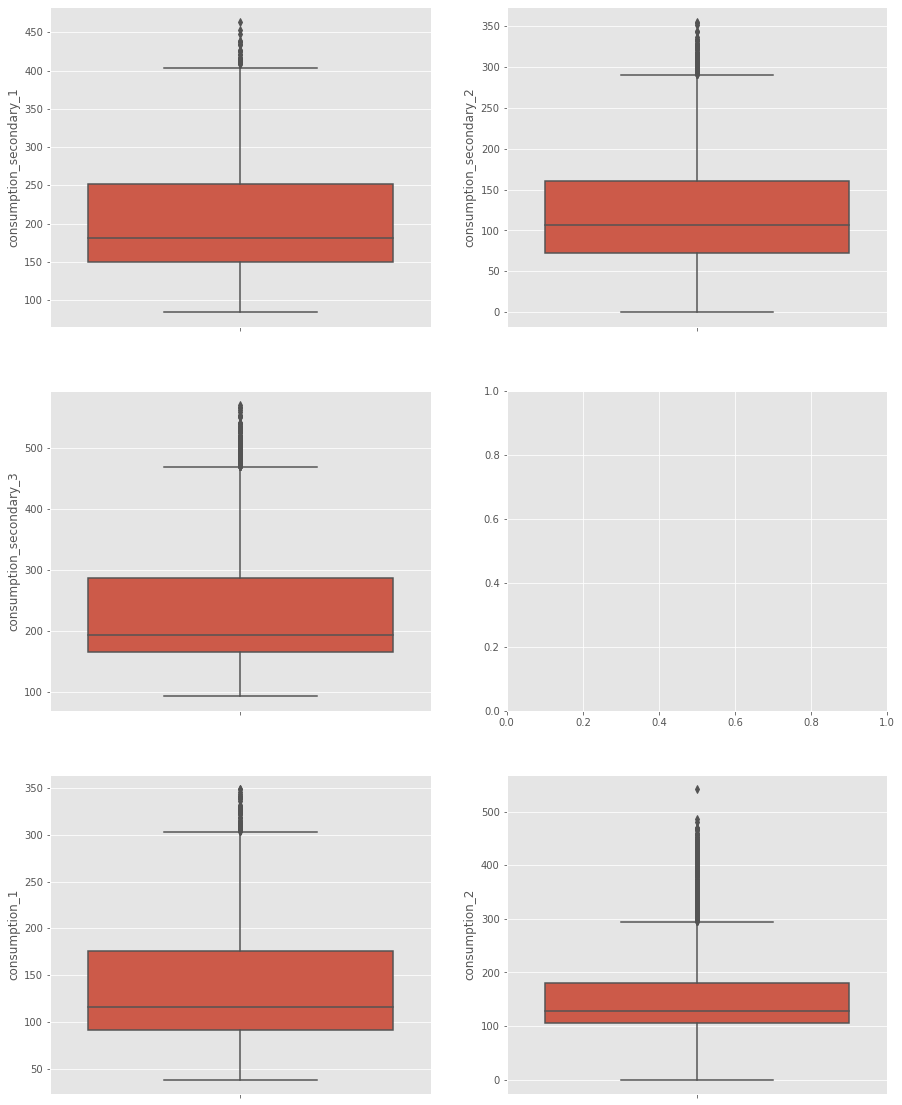

In [221]:
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(15, 20)
sns.boxplot(data=data,y="consumption_secondary_1",orient="v",ax=axes[0][0])
sns.boxplot(data=data,y="consumption_secondary_2",orient="v",ax=axes[0][1])
sns.boxplot(data=data,y="consumption_secondary_3",orient="v",ax=axes[1][0])
sns.boxplot(data=data,y="consumption_1",orient="v",ax=axes[2][0])
sns.boxplot(data=data,y="consumption_2",orient="v",ax=axes[2][1])

In [222]:
#outliers?

In [223]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
data.head(20)

,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,consumption_1,consumption_2
1970-01-01 00:00:00.000000000,8.3,12.646197,11.1,95.0,64.199721,143.0,74.0,168.0,100.0,93.0
1970-01-01 00:00:00.000000001,8.0,12.406369,11.1,98.0,64.630573,141.0,60.0,162.0,101.0,94.0
1970-01-01 00:00:00.000000002,6.8,12.370460,11.0,97.0,64.289843,142.0,60.0,164.0,100.0,96.0
1970-01-01 00:00:00.000000003,7.5,12.202367,10.9,99.0,64.462999,139.0,60.0,162.0,101.0,95.0
1970-01-01 00:00:00.000000004,6.1,12.124018,10.8,98.0,64.219439,154.0,60.0,164.0,100.0,100.0
1970-01-01 00:00:00.000000005,5.4,11.948273,10.7,98.0,64.109077,184.0,62.0,167.0,100.0,110.0
1970-01-01 00:00:00.000000006,5.0,11.898124,10.5,99.0,64.887675,182.0,78.0,173.0,115.0,110.0
1970-01-01 00:00:00.000000007,5.1,11.993624,10.2,99.0,65.358327,165.0,79.0,175.0,145.0,108.0
1970-01-01 00:00:00.000000008,4.7,11.933599,10.2,99.0,65.125344,157.0,80.0,176.0,141.0,110.0
1970-01-01 00:00:00.000000009,5.5,11.950157,10.3,100.0,65.702367,153.0,86.0,175.0,143.0,109.0


In [224]:
# Loop to check all columns of the DF
import functools
data.apply(functools.partial(test_stationarity))

Results of Dickey-Fuller Test:
Test Statistic                   -3.581538
p-value                           0.006124
#Lags Used                       37.000000
Number of Observations Used    8722.000000
Critical Value (1%)              -3.431100
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   -3.343758
p-value                           0.013032
#Lags Used                       28.000000
Number of Observations Used    8731.000000
Critical Value (1%)              -3.431099
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   -2.307181
p-value                           0.169663
#Lags Used                       37.000000
Number of Observations Used    8722.000000
Critical Value (1%)              -3.431100
Critical Value (5%)              -2.861871
Critical Value (1

temp_1                     None
temp_2                     None
mean_national_temp         None
humidity_1                 None
humidity_2                 None
consumption_secondary_1    None
consumption_secondary_2    None
consumption_secondary_3    None
consumption_1              None
consumption_2              None
dtype: object

In [227]:
# Differencing to get the data stationary
dataDiff = data.diff().dropna()
dataDiff.head()

,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,consumption_1,consumption_2
1970-01-01 00:00:00.000000001,-0.3,-0.239829,0.0,3.0,0.430852,-2.0,-14.0,-6.0,1.0,1.0
1970-01-01 00:00:00.000000002,-1.2,-0.035908,-0.1,-1.0,-0.340730,1.0,0.0,2.0,-1.0,2.0
1970-01-01 00:00:00.000000003,0.7,-0.168093,-0.1,2.0,0.173156,-3.0,0.0,-2.0,1.0,-1.0
1970-01-01 00:00:00.000000004,-1.4,-0.078349,-0.1,-1.0,-0.243560,15.0,0.0,2.0,-1.0,5.0
1970-01-01 00:00:00.000000005,-0.7,-0.175745,-0.1,0.0,-0.110363,30.0,2.0,3.0,0.0,10.0


In [229]:
dataDiff.apply(functools.partial(test_stationarity))    

Results of Dickey-Fuller Test:
Test Statistic                -1.882194e+01
p-value                        2.022180e-30
#Lags Used                     3.700000e+01
Number of Observations Used    8.721000e+03
Critical Value (1%)           -3.431100e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -22.601454
p-value                           0.000000
#Lags Used                       27.000000
Number of Observations Used    8731.000000
Critical Value (1%)              -3.431099
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.142958e+01
p-value                        6.566916e-21
#Lags Used                     3.700000e+01
Number of Observations Used    8.721000e+03
Critical Value (1%)           -3.431100e+00
Critical Value (5%)           -2.861871e+00
Crit

temp_1                     None
temp_2                     None
mean_national_temp         None
humidity_1                 None
humidity_2                 None
consumption_secondary_1    None
consumption_secondary_2    None
consumption_secondary_3    None
consumption_1              None
consumption_2              None
dtype: object

In [232]:
# Creating the VAR model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(dataDiff)

/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  % freq, ValueWarning)


In [233]:
# Best model order
modsel = model.select_order(15)
modsel.summary()

,AIC,BIC,FPE,HQIC
0,28.96,28.96,3.765e+12,28.96
1,26.22,26.30,2.428e+11,26.25
2,25.76,25.93,1.544e+11,25.82
3,25.63,25.88,1.349e+11,25.71
4,25.35,25.68,1.023e+11,25.46
5,25.18,25.60,8.664e+10,25.33
6,25.05,25.54,7.577e+10,25.22
7,24.88,25.45,6.363e+10,25.07
8,24.78,25.43,5.768e+10,25.00
9,24.63,25.37,4.970e+10,24.88


In [234]:
# Automated model order selection
results = model.fit(maxlags=15, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 11, Jul, 2019
Time:                     19:22:06
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    25.1861
Nobs:                     8744.00    HQIC:                   24.3805
Log likelihood:          -227333.    FPE:                2.55561e+10
AIC:                      23.9641    Det(Omega_mle):     2.15346e+10
--------------------------------------------------------------------
Results for equation temp_1
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                              -0.000163         0.007251           -0.022           0.982
L1.temp_1                           0.280540         0.013914           20.163           0.000
L1.

In [236]:
grangres = results.test_causality('consumption_1', ['temp_1', 'mean_national_temp', 'humidity_1'], kind='f')
grangres.summary

<bound method HypothesisTestResults.summary of <statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object at 0x7fd97e419f28>>

In [238]:
processing(dataInt, dataTest)

(        ID              timestamp  temp_1  temp_2  mean_national_temp  \
 0        0  2016-11-01T00:00:00.0     8.3     NaN                11.1   
 1        1  2016-11-01T01:00:00.0     8.0     NaN                11.1   
 2        2  2016-11-01T02:00:00.0     6.8     NaN                11.0   
 3        3  2016-11-01T03:00:00.0     7.5     NaN                10.9   
 4        4  2016-11-01T04:00:00.0     6.1     NaN                10.8   
 5        5  2016-11-01T05:00:00.0     5.4     NaN                10.7   
 6        6  2016-11-01T06:00:00.0     5.0     NaN                10.5   
 7        7  2016-11-01T07:00:00.0     5.1     NaN                10.2   
 8        8  2016-11-01T08:00:00.0     4.7     NaN                10.2   
 9        9  2016-11-01T09:00:00.0     5.5     NaN                10.3   
 10      10  2016-11-01T10:00:00.0     8.6     NaN                10.7   
 11      11  2016-11-01T11:00:00.0    10.4     NaN                11.4   
 12      12  2016-11-01T12:00:00.0    

In [241]:
dataInt.head()

,ID,timestamp,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,loc_1,loc_2,loc_secondary_1,loc_secondary_2,loc_secondary_3,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3
0,0,2016-11-01T00:00:00.0,8.3,NaN,11.1,95.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",143,74,168
1,1,2016-11-01T01:00:00.0,8.0,NaN,11.1,98.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",141,60,162
2,2,2016-11-01T02:00:00.0,6.8,NaN,11.0,97.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",142,60,164
3,3,2016-11-01T03:00:00.0,7.5,NaN,10.9,99.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",139,60,162
4,4,2016-11-01T04:00:00.0,6.1,NaN,10.8,98.0,NaN,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",154,60,164


In [243]:
dataOut.head()

,ID,consumption_1,consumption_2
0,0,100,93
1,1,101,94
2,2,100,96
3,3,101,95
4,4,100,100


In [242]:
dataTest.head()

,ID,timestamp,temp_1,temp_2,mean_national_temp,humidity_1,humidity_2,loc_1,loc_2,loc_secondary_1,loc_secondary_2,loc_secondary_3,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3
0,8760,2017-11-01T00:00:00.0,6.5,7.1,8.8,91.0,82.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",190,126,177
1,8761,2017-11-01T01:00:00.0,6.8,7.0,8.7,89.0,87.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",189,116,172
2,8762,2017-11-01T02:00:00.0,6.8,6.3,8.7,88.0,91.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",195,117,175
3,8763,2017-11-01T03:00:00.0,5.8,5.8,8.6,90.0,93.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",197,115,171
4,8764,2017-11-01T04:00:00.0,5.0,5.6,8.5,90.0,94.0,"(50.633, 3.067)","(43.530, 5.447)","(44.838, -0.579)","(47.478, -0.563)","(48.867, 2.333)",198,115,174


In [244]:
#SPLIT
tscv = TimeSeriesSplit(n_splits=10)
print(tscv)
for train_index, test_index in tscv.split(dataInt):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = dataInt.iloc[train_index, :], dataInt.iloc[test_index, :]
    y_train, y_test = dataOut.iloc[train_index, :], dataOut.iloc[test_index, :]
    
# jeu de donnees propres:
    # X-train et y_train pour faire le modele
    # X_test et y_test pour tester mon modele
    # dataTest pour la soumission 

TimeSeriesSplit(max_train_size=None, n_splits=10)
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 23

In [240]:
## gerer les dummies et les variables num
Xtrain_new = d_tr.drop(['ID'], axis=1)
print(Xtrain_new.shape)
featuresObject = ['season', 'year', 'month', 'hours', 'is_business_day', 'is_holiday']
for var in featuresObject:
    Xtrain_new[var] = Xtrain_new[var].astype('category')
Xtrain_new.dtypes

(796, 14)


temp_1                      float64
temp_2                      float64
mean_national_temp          float64
humidity_1                  float64
humidity_2                  float64
consumption_secondary_1     float64
consumption_secondary_2     float64
consumption_secondary_3     float64
year                       category
month                      category
hours                      category
is_business_day            category
is_holiday                 category
season                     category
dtype: object

In [ ]:
col_name_train = [f for f in Xtrain_new.columns if Xtrain_new[f].dtype == float]
type(col_name_train)

In [ ]:
Xtrain_new[col_name_train].dtypes

In [119]:
numeric_features_train = Xtrain_new[col_name_train]
type(numeric_features_train)

pandas.core.frame.DataFrame

In [121]:
Xtrain_new[col_name_train].dtypes

temp_1                     float64
temp_2                     float64
mean_national_temp         float64
humidity_1                 float64
humidity_2                 float64
consumption_secondary_1    float64
consumption_secondary_2    float64
consumption_secondary_3    float64
dtype: object

In [139]:
# Les Num
ct_num = ColumnTransformer([
        ('stdScal', StandardScaler(), ['temp_1','temp_2','mean_national_temp','humidity_1',
         'humidity_2','consumption_secondary_1','consumption_secondary_2','consumption_secondary_3'])],
    remainder='passthrough')
X_tr = ct_num.fit_transform(numeric_features_train)
Xtrain_new[col_name_train] = pd.DataFrame(X_tr, columns=numeric_features_train.columns, index = list(X_train.index.values))




In [140]:
type(X_tr)

numpy.ndarray

In [141]:
Xtrain_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7964 entries, 0 to 7963
Data columns (total 14 columns):
temp_1                     7964 non-null float64
temp_2                     7964 non-null float64
mean_national_temp         7964 non-null float64
humidity_1                 7964 non-null float64
humidity_2                 7964 non-null float64
consumption_secondary_1    7964 non-null float64
consumption_secondary_2    7964 non-null float64
consumption_secondary_3    7964 non-null float64
year                       7964 non-null category
month                      7964 non-null category
hours                      7964 non-null category
is_business_day            7964 non-null category
is_holiday                 7964 non-null category
season                     7964 non-null category
dtypes: category(6), float64(8)
memory usage: 928.3 KB


In [142]:
type(Xtrain_new)

pandas.core.frame.DataFrame

In [143]:
## verifier les resultats de la sortie de X_tr
print(np.mean(X_tr,axis=0))### moyenne 
print(np.std(X_tr,axis=0,ddof=0)) ### ecart type

[ 1.14200741e-16 -1.14200741e-16  0.00000000e+00 -3.42602223e-16
  1.71301112e-16  1.14200741e-16 -2.85501853e-17 -5.71003705e-17]
[1. 1. 1. 1. 1. 1. 1. 1.]


In [144]:
# Gerer les variables categoriques
ct = ColumnTransformer([
        ('oh_enc', 
         OneHotEncoder(sparse=False), 
         [8,9,10,11,12,13]),])
d_1he = ct.fit_transform(Xtrain_new)
d_encoded_data = pd.DataFrame(d_1he, columns=ct.get_feature_names())
d_encoded_data.drop(['oh_enc__x0_2016', 'oh_enc__x1_1','oh_enc__x2_0', 'oh_enc__x3_0','oh_enc__x4_0', 'oh_enc__x5_fall'], inplace=True, axis=1)
df_concat = pd.concat([Xtrain_new.reset_index(drop=True), d_encoded_data.reset_index(drop=True)], axis=1)
df_concat.drop(['season', 'year', 'month', 'hours', 'is_business_day', 'is_holiday'], inplace=True, axis=1)
X_trained = df_concat[:dataInt.shape[0]]
X_trained.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7964 entries, 0 to 7963
Data columns (total 47 columns):
temp_1                     7964 non-null float64
temp_2                     7964 non-null float64
mean_national_temp         7964 non-null float64
humidity_1                 7964 non-null float64
humidity_2                 7964 non-null float64
consumption_secondary_1    7964 non-null float64
consumption_secondary_2    7964 non-null float64
consumption_secondary_3    7964 non-null float64
oh_enc__x0_2017            7964 non-null float64
oh_enc__x1_2               7964 non-null float64
oh_enc__x1_3               7964 non-null float64
oh_enc__x1_4               7964 non-null float64
oh_enc__x1_5               7964 non-null float64
oh_enc__x1_6               7964 non-null float64
oh_enc__x1_7               7964 non-null float64
oh_enc__x1_8               7964 non-null float64
oh_enc__x1_9               7964 non-null float64
oh_enc__x1_11              7964 non-null float64
oh_enc__x1_

In [145]:
dI = X_test.copy()
## missing value
dI_num = dI.drop(['timestamp','loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2', 'loc_secondary_3'], axis=1)
imputed_training_mice=mice(dI_num.values)
data_mice = pd.DataFrame(imputed_training_mice, columns=dI_num.columns, index = list(dI.index.values))
dI_NonNum = dI.select_dtypes(include=[np.object])
dClean = data_mice.join(dI_NonNum)


In [146]:

## drop variable inutile
d_tr = dClean.drop(['loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2', 'loc_secondary_3'], axis=1)
## create extra attribute

conv(d_tr)
d_tr['timestamp'] = pd.to_datetime(d_tr.timestamp, format = '%Y-%m-%dT%H:%M:%S.%f')
## create season and rangeInYear
s = pd.to_datetime(pd.Series(d_tr['timestamp']))
d_tr['rangeInYear'] = s.dt.strftime('%j').astype(int)
#create jours working days
d_tr['is_business_day'] = d_tr['datetime_perso'].apply(lambda e : int(business_day(e)))
# Is it an holiday for zone A, B or C?
d = SchoolHolidayDates()
d_tr['is_holiday'] = d_tr['datetime_perso'].apply(lambda f : int(d.is_holiday(datetime.date(f))))
d_tr['season'] = d_tr['rangeInYear'].apply(lambda d : get_season(d))
d_tr= d_tr.drop(['rangeInYear', 'datetime_perso', 'date', 'timestamp'], axis=1)
d_tr.info() #  A ENLEVER

<class 'pandas.core.frame.DataFrame'>
Int64Index: 796 entries, 7964 to 8759
Data columns (total 15 columns):
ID                         796 non-null float64
temp_1                     796 non-null float64
temp_2                     796 non-null float64
mean_national_temp         796 non-null float64
humidity_1                 796 non-null float64
humidity_2                 796 non-null float64
consumption_secondary_1    796 non-null float64
consumption_secondary_2    796 non-null float64
consumption_secondary_3    796 non-null float64
year                       796 non-null int64
month                      796 non-null int64
hours                      796 non-null int64
is_business_day            796 non-null int64
is_holiday                 796 non-null int64
season                     796 non-null object
dtypes: float64(9), int64(5), object(1)
memory usage: 139.5+ KB


In [147]:
## gerer les dummies et les variables num
Xtest_new1 = d_tr.drop(['ID'], axis=1)
featuresObject = ['season', 'year', 'month', 'hours', 'is_business_day', 'is_holiday']
for var in featuresObject:
    Xtest_new1[var] = Xtest_new1[var].astype('category')
Xtest_new1.info()
Xtest_new = Xtest_new1.copy()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 796 entries, 7964 to 8759
Data columns (total 14 columns):
temp_1                     796 non-null float64
temp_2                     796 non-null float64
mean_national_temp         796 non-null float64
humidity_1                 796 non-null float64
humidity_2                 796 non-null float64
consumption_secondary_1    796 non-null float64
consumption_secondary_2    796 non-null float64
consumption_secondary_3    796 non-null float64
year                       796 non-null category
month                      796 non-null category
hours                      796 non-null category
is_business_day            796 non-null category
is_holiday                 796 non-null category
season                     796 non-null category
dtypes: category(6), float64(8)
memory usage: 101.9 KB


In [148]:
col_name_test = [f for f in Xtest_new.columns if Xtest_new[f].dtype == float]
type(col_name_test)

list

In [149]:
numeric_features_test = Xtest_new[col_name_test]
type(numeric_features_test)

pandas.core.frame.DataFrame

In [150]:
Xtest_new[col_name_test].dtypes

temp_1                     float64
temp_2                     float64
mean_national_temp         float64
humidity_1                 float64
humidity_2                 float64
consumption_secondary_1    float64
consumption_secondary_2    float64
consumption_secondary_3    float64
dtype: object

In [155]:
X_te = ct_num.fit(numeric_features_test)
Xtest_new[col_name_test] = pd.DataFrame(X_te, columns=numeric_features_test.columns, index = list(X_test.index.values))

type(X_te)

sklearn.compose._column_transformer.ColumnTransformer

In [156]:
Xtest_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 796 entries, 7964 to 8759
Data columns (total 14 columns):
temp_1                     796 non-null object
temp_2                     796 non-null object
mean_national_temp         796 non-null object
humidity_1                 796 non-null object
humidity_2                 796 non-null object
consumption_secondary_1    796 non-null object
consumption_secondary_2    796 non-null object
consumption_secondary_3    796 non-null object
year                       796 non-null category
month                      796 non-null category
hours                      796 non-null category
is_business_day            796 non-null category
is_holiday                 796 non-null category
season                     796 non-null category
dtypes: category(6), object(8)
memory usage: 61.9+ KB


In [157]:
print(type(X_te))
print(X_te[0])

<class 'sklearn.compose._column_transformer.ColumnTransformer'>


TypeError: 'ColumnTransformer' object is not subscriptable

In [154]:
numeric_features_test = scaler.transform(numeric_features_test.values)



NameError: name 'scaler' is not defined

In [109]:
# les num
X_tr_test = ct_num.fit(numeric_features_test)
Xtest_new[numeric_features_col_name_test] = pd.DataFrame(X_tr_test, columns=numeric_features_test.columns, index = list(X_test.index.values))
Xtest_new.info()
# Gerer les variables categoriques

NameError: name 'numeric_features_col_name_test' is not defined

In [110]:
Xtest_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 796 entries, 7964 to 8759
Data columns (total 14 columns):
temp_1                     796 non-null object
temp_2                     796 non-null object
mean_national_temp         796 non-null object
humidity_1                 796 non-null object
humidity_2                 796 non-null object
consumption_secondary_1    796 non-null object
consumption_secondary_2    796 non-null object
consumption_secondary_3    796 non-null object
year                       796 non-null category
month                      796 non-null category
hours                      796 non-null category
is_business_day            796 non-null category
is_holiday                 796 non-null category
season                     796 non-null category
dtypes: category(6), object(8)
memory usage: 61.9+ KB


In [42]:

d_1he_test = ct.fit(Xtest_new)

Xtest_new.info()
Xtrain_new.info()
d_encoded_data = pd.DataFrame(d_1he_test, columns=ct.get_feature_names(), index = list(X_test.index.values))
d_encoded_data.drop(['oh_enc__x0_2016', 'oh_enc__x1_1','oh_enc__x2_0', 'oh_enc__x3_0','oh_enc__x4_0', 'oh_enc__x5_fall'], inplace=True, axis=1)
df_concat = pd.concat([Xtest_new.reset_index(drop=True), d_encoded_data.reset_index(drop=True)], axis=1)
df_concat.drop(['season', 'year', 'month', 'hours', 'is_business_day', 'is_holiday'], inplace=True, axis=1)
X_test_trained = df_concat[:dataInt.shape[0]]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 796 entries, 7964 to 8759
Data columns (total 14 columns):
temp_1                     796 non-null object
temp_2                     796 non-null object
mean_national_temp         796 non-null object
humidity_1                 796 non-null object
humidity_2                 796 non-null object
consumption_secondary_1    796 non-null object
consumption_secondary_2    796 non-null object
consumption_secondary_3    796 non-null object
year                       796 non-null category
month                      796 non-null category
hours                      796 non-null category
is_business_day            796 non-null category
is_holiday                 796 non-null category
season                     796 non-null category
dtypes: category(6), object(8)
memory usage: 101.9+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 796 entries, 7964 to 8759
Data columns (total 14 columns):
temp_1                     796 non-null object
temp_2    

KeyError: "['oh_enc__x0_2016' 'oh_enc__x1_1'] not found in axis"

In [31]:
### POUR COMPRENDRE CE QUI SE PASSE A LA SORTIE DE STDSCALER

In [33]:
import pandas as pd
data = pd.DataFrame({'Name' : [3, 4,6], 'Age' : [18, 92,98], 'Weight' : [68, 59,49]})


In [34]:
data

,Name,Age,Weight
0,3,18,68
1,4,92,59
2,6,98,49


In [35]:
col_names = ['Name', 'Age', 'Weight']
features = data[col_names]

In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [37]:
ct = ColumnTransformer([
        ('somename', StandardScaler(), ['Age', 'Weight'])
    ], remainder='passthrough')

In [42]:
ct.fit_transform(features)

array([[-1.41100443,  1.20270298,  3.        ],
       [ 0.62304092,  0.04295368,  4.        ],
       [ 0.78796352, -1.24565666,  6.        ]])

In [46]:
Z = ct.fit_transform(features)


In [47]:
ct.fit_transform(features)

array([[-1.41100443,  1.20270298,  3.        ],
       [ 0.62304092,  0.04295368,  4.        ],
       [ 0.78796352, -1.24565666,  6.        ]])

In [51]:
print(np.mean(Z,axis=0))
print(np.std(Z,axis=0,ddof=0))

[1.11022302e-16 2.96059473e-16 4.33333333e+00]
[1.         1.         1.24721913]
